# Bagging Classification with Python

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
# Surpress numpy data type warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Once again we use the customer churn dataset. We'll select some features to use and do the following preprocessing steps:

- Target variable to integer

In [2]:
# Helper methods

from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as Tree

def get_accuracy(X_train, X_test, y_train, y_test, model):
    return {
        "test Accuracy": metrics.accuracy_score(
            y_test, 
            model.predict(X_test)
            ),
        "train Accuracy": metrics.accuracy_score(
            y_train, 
            model.predict(X_train)
            )
        }
    
def plot_tree(model, df, features, filename = "tree.png"):

    dot_data = StringIO()
  
    #featureNames = [column for column in df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip']].columns]
    _ = Tree.export_graphviz(
        model,
        feature_names = features,
        out_file = dot_data,
        class_names = ['left','stay'],
        filled = True,
        special_characters = True,
        rotate = False
        )  
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png(filename)
    img = mpimg.imread(filename)
    plt.figure(figsize=(100, 200))
    plt.imshow(img,interpolation='nearest')
    
def get_accuracy_bag(X, y, title, times=20, xlabel='Number Estimators'):
    # Iterate through different number of estimators and average out the results  

    N_estimators = [n for n in range(1,70)]
    
    # Keep track of the accuracy for each 
    train_acc = np.zeros((times,len(N_estimators)))
    test_acc  = np.zeros((times,len(N_estimators)))

    # Train each number of estimators N, n times, with different data splits
    # Afterwards average the results and plot
    for n in tqdm(range(times)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        
        for n_estimators in N_estimators:
            Bag = BaggingClassifier(
                estimator = DecisionTreeClassifier(
                    criterion = "entropy", 
                    max_depth = 10),
                n_estimators = n_estimators,
                bootstrap = True,
                random_state = 0)
            
            Bag.fit(X_train,y_train)
            
            Accuracy=get_accuracy(X_train, X_test, y_train, y_test,  Bag)

            train_acc[n,n_estimators-1]=Accuracy['train Accuracy']
            test_acc[n,n_estimators-1]=Accuracy['test Accuracy']
         
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(train_acc.mean(axis=0))
    ax2.plot(test_acc.mean(axis=0),c='r')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('Training accuracy',color='b')
    ax2.set_ylabel('Testing accuracy', color='r')
    plt.title(title)
    plt.show()

In [3]:
df = pd.read_csv("./data/ChurnData.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tenure    200 non-null    float64
 1   age       200 non-null    float64
 2   address   200 non-null    float64
 3   income    200 non-null    float64
 4   ed        200 non-null    float64
 5   employ    200 non-null    float64
 6   equip     200 non-null    float64
 7   callcard  200 non-null    float64
 8   wireless  200 non-null    float64
 9   longmon   200 non-null    float64
 10  tollmon   200 non-null    float64
 11  equipmon  200 non-null    float64
 12  cardmon   200 non-null    float64
 13  wiremon   200 non-null    float64
 14  longten   200 non-null    float64
 15  tollten   200 non-null    float64
 16  cardten   200 non-null    float64
 17  voice     200 non-null    float64
 18  pager     200 non-null    float64
 19  internet  200 non-null    float64
 20  callwait  200 non-null    float6

In [4]:
df.shape, df.columns, df.churn.value_counts()

((200, 28),
 Index(['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip',
        'callcard', 'wireless', 'longmon', 'tollmon', 'equipmon', 'cardmon',
        'wiremon', 'longten', 'tollten', 'cardten', 'voice', 'pager',
        'internet', 'callwait', 'confer', 'ebill', 'loglong', 'logtoll',
        'lninc', 'custcat', 'churn'],
       dtype='object'),
 churn
 0.0    142
 1.0     58
 Name: count, dtype: int64)

## Model training

First, prepare the target data as an integer, then split up train/test splits and build a basic DecisionTreeClassifier.

In [5]:
features = ['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip', 'callcard', 'wireless']
target = 'churn'

X = df[features]
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=10)
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

get_accuracy(X_train, X_test, y_train, y_test, decision_tree)

{'test Accuracy': 0.6166666666666667, 'train Accuracy': 0.9071428571428571}

Train accuracy is not great, but test accuracy is even worse, the tree is clearly overfitting. Which is to be expected from a basic DecisionTree.

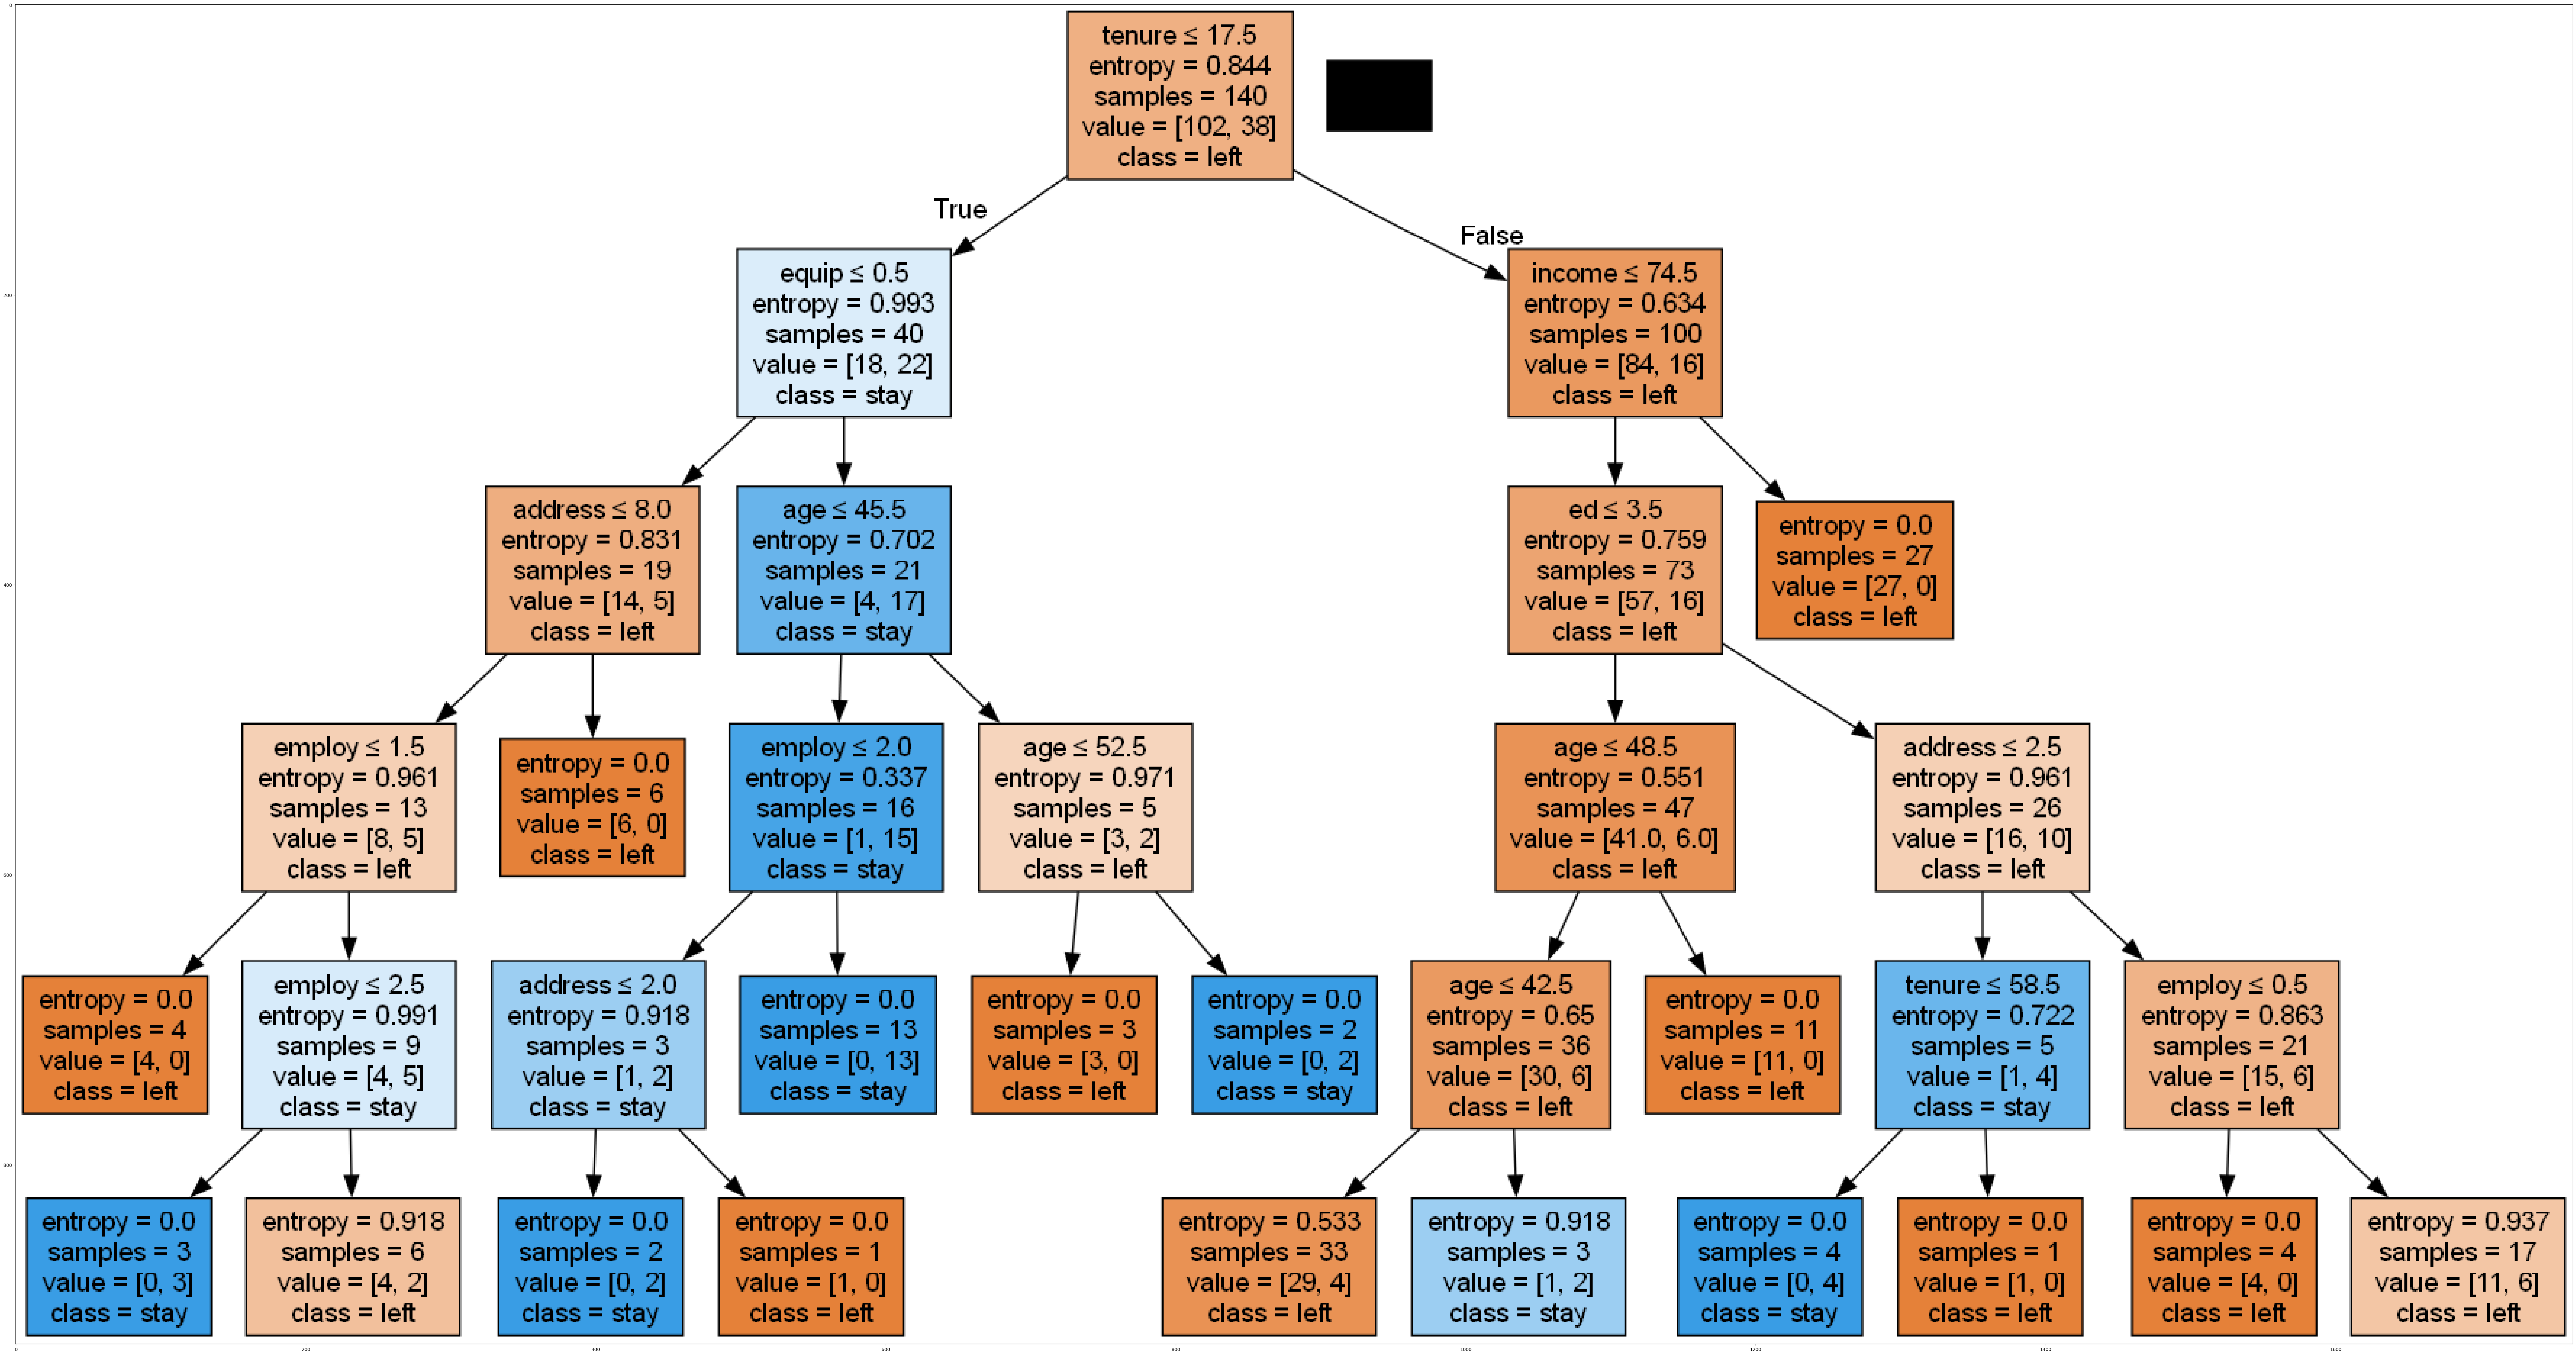

In [6]:
plot_tree(filename = "./images/churn_tree_01.png", model = decision_tree, df = df, features=features)

## Adding Bagging

Using Bootstrap AGGregation (BAGGing), makes it so a tree will overfit less. Bagging is an ensemble tree model that trains multiple trees on different subsets of the data. Afterwards a majority vote is done which decides the result of the classification. 

In [7]:
from sklearn.ensemble import BaggingClassifier

bagging_classifier = BaggingClassifier(
    estimator = DecisionTreeClassifier(
        criterion = 'entropy',
        max_depth = 4,
        random_state = 2
    ),
    n_estimators = 30,
    random_state = 0,
    bootstrap = True
)

bagging_classifier.fit(X_train, y_train)
y_pred = bagging_classifier.predict(X_test)

get_accuracy(X_train, X_test, y_train, y_test, bagging_classifier)

{'test Accuracy': 0.65, 'train Accuracy': 0.9071428571428571}

The train accuracy does not improve, but the test accuracy is a little better. Still not anything near usable though.

We can use the helper function defined earlier to check the accuracy of the model when more estimators are used. This function trains a Bagging classifier with different amounts of estimators, multiple times with different data splits. Afterwards the results are plotted.

100%|██████████| 20/20 [01:23<00:00,  4.18s/it]


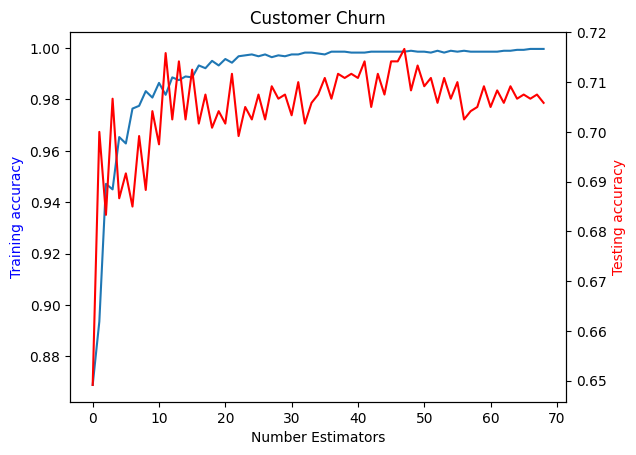

In [8]:
get_accuracy_bag(X, y, "Customer Churn")

## Low Variance Example

Bagging does not work well when the data has low variance (performs similarly on train and test data). For example, when using SVC as the base estimator, which already performs well on its own, the results do not improve significantly.

In [ ]:
from sklearn.svm import SVC

svc = SVC(kernel='linear',gamma='scale')
svc.fit(X_train, y_train) 
get_accuracy(X_train, X_test, y_train, y_test, svc)

{'test Accuracy': 0.7166666666666667, 'train Accuracy': 0.8}

With a bagging wrapper:

In [10]:
bagging_svc = BaggingClassifier(
    estimator = svc,
    n_estimators = 10,
    random_state = 0,
    bootstrap = True
)

bagging_svc.fit(X_train, y_train)
get_accuracy(X_train, X_test, y_train, y_test, bagging_svc)

{'test Accuracy': 0.7, 'train Accuracy': 0.8142857142857143}

## Cancer Data

Let's now try bagging with the cancer data from the previous exercises. We'll use gridsearch to find the best parameter values for:

- n_estimators
- max_depth

In [11]:
from sklearn.model_selection import GridSearchCV

features = ['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']
target = "Class"

df = pd.read_csv("./data/cell_samples.csv")
# Remove unknown data in "BareNuc" column
df = df[df["BareNuc"] != "?"]

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

classifier = BaggingClassifier(
    estimator = DecisionTreeClassifier(
        criterion = "entropy",
        random_state = 0
    ),
    random_state = 0,
    bootstrap = True
)

param_grid = {
    "n_estimators": [2*n+1 for n in range(20)],
    "estimator__max_depth": [2*n+1 for n in range(10)]
}

search = GridSearchCV(
    estimator = classifier, 
    param_grid = param_grid,
    scoring = "accuracy",
    cv = 3)

search.fit(X_train, y_train)
search.best_score_

np.float64(0.9725274725274726)

That is quite good, the best score being 0.97. Let's see which parameters achive this performance and what the eventual classifier looks liek.

In [12]:
search.best_params_

{'estimator__max_depth': 3, 'n_estimators': 29}

In [13]:
get_accuracy(X_train, X_test, y_train, y_test, search.best_estimator_)

{'test Accuracy': 0.9708029197080292, 'train Accuracy': 0.9816849816849816}

100%|██████████| 20/20 [01:44<00:00,  5.20s/it]


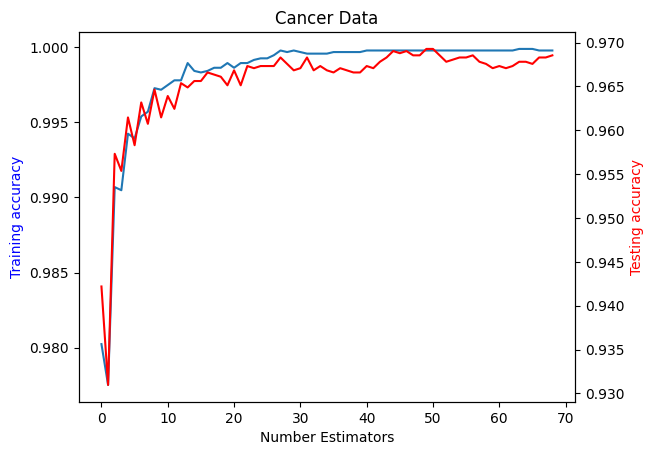

In [14]:
get_accuracy_bag(X, y, "Cancer Data")

## Bagging drugs

Finally, we can also use the drug dataset from before. In this case we will be making a multiclass classifier which will predict the type of drug.

Again, we'll use gridsearch to find the best parameters for:
- n_estimators
- estimator max_depth

In [30]:
from sklearn.preprocessing import LabelEncoder

features = ['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']
target = "Drug"

df = pd.read_csv("./data/drug200.csv")

X = df[features]
y = df[target]

# Encode all categorical columns as integers
le_sex = LabelEncoder()
X.loc[:, 'Sex'] = le_sex.fit_transform(X['Sex'])

le_BP = LabelEncoder()
X.loc[:, 'BP'] = le_BP.fit_transform(X['BP'])

le_Chol = LabelEncoder()
X.loc[:, 'Cholesterol'] = le_Chol.fit_transform(X['Cholesterol'])

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

param_grid = {
    'n_estimators': [2*n+1 for n in range(20)],
    'estimator__max_depth' : [2*n+1 for n in range(10)]
    }

classifier = BaggingClassifier(
    estimator = DecisionTreeClassifier(
        criterion = 'entropy',
        random_state = 0
    ),
    random_state = 0,
    bootstrap = True
)

gs = GridSearchCV(
    estimator = classifier,
    param_grid = param_grid,
    scoring = 'accuracy',
    cv = 3
)

gs.fit(X_train, y_train)
gs.best_score_

np.float64(1.0)

In [31]:
gs.best_params_

{'estimator__max_depth': 5, 'n_estimators': 3}

In [34]:
get_accuracy(X_train, X_test, y_train, y_test, gs.best_estimator_)

{'test Accuracy': 0.95, 'train Accuracy': 1.0}

100%|██████████| 20/20 [01:17<00:00,  3.86s/it]


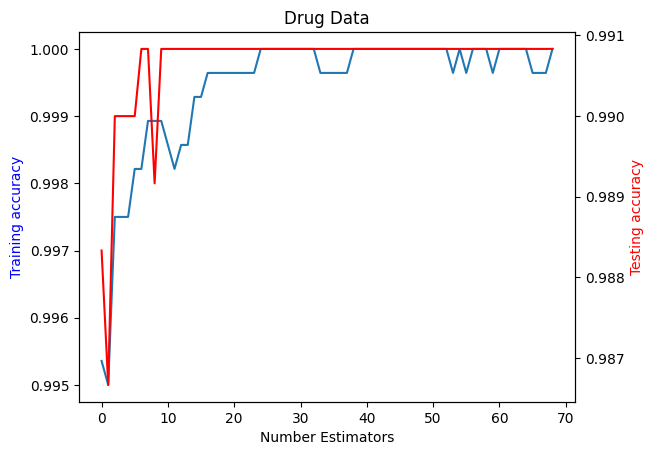

In [33]:
get_accuracy_bag(X, y, "Drug Data")